# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import matplotlib.pyplot as plt

#30_paritions
optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])


def get_models_and_shapes(eeg_file='../../optimized_nets/eeg/eeg_30_partitions.json', 
                          bold_file='../../optimized_nets/bold/bold_30_partitions.json',
                          decoder_file='../../optimized_nets/decoder/decoder_30_partitions.json'):
    json_file = open(eeg_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    eeg_network = tf.keras.models.model_from_json(loaded_model_json)
    
    json_file = open(bold_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    bold_network = tf.keras.models.model_from_json(loaded_model_json)
    
    json_file = open(decoder_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    decoder_network = tf.keras.models.model_from_json(loaded_model_json)
    
    return eeg_network, bold_network, decoder_network


def _plot_mean_std(reconstruction_loss, distance, tset="train", n_partitions=30, model="M", ax=None):

    inds_ids = []
    inds_mean = np.zeros(len(reconstruction_loss)//n_partitions)
    inds_std = np.zeros(len(reconstruction_loss)//n_partitions)
    
    #compute mean 
    for ind in range(inds_mean.shape[0]):
        inds_ids += ['Ind_' + str(ind+1)]
        inds_mean[ind] = np.mean(reconstruction_loss[ind:ind+n_partitions])
        inds_std[ind] = np.std(reconstruction_loss[ind:ind+n_partitions])
        
    print(tset + " set", "mean: ", np.mean(reconstruction_loss))
    print(tset + " set", "std: ", np.std(reconstruction_loss))
    
    
    ax.errorbar(inds_ids, inds_mean, inds_std, linestyle='None', elinewidth=0.5, ecolor='r', capsize=10.0, markersize=10.0, marker='o')
    ax.set_title(distance + " on " + tset + " set " + " (" + model + ")")
    ax.set_xlabel("Individuals")
    if("Cosine" in distance):
        ax.set_ylabel("Correlation")
    else:
        ax.set_ylabel("Distance")

def _plot_mean_std_loss(synthesized_bold, bold, distance_function, distance_name, set_name, model_name, ax=None):
    reconstruction_loss = np.zeros((synthesized_bold.shape[0], 1))

    for instance in range(len(reconstruction_loss)):
        instance_synth = synthesized_bold[instance]
        instance_bold = bold[instance]

        instance_synth = instance_synth.reshape((1, instance_synth.shape[0], instance_synth.shape[1], instance_synth.shape[2]))
        instance_bold = instance_bold.reshape((1, instance_bold.shape[0], instance_bold.shape[1], instance_bold.shape[2]))

        reconstruction_loss[instance] = distance_function(instance_synth, instance_bold).numpy()

    _plot_mean_std(reconstruction_loss, distance=distance_name, tset=set_name, model=model_name, ax=ax)

    
    
def plot_mean_std_loss(eeg_train, bold_train, 
                       eeg_val, bold_val, 
                       eeg_test, bold_test, 
                       encoder_network, decoder_network, 
                       distance_name, distance_function,
                       model_name):
    
    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(131)
    
    shared_eeg_train = encoder_network.predict(eeg_train)
    synthesized_bold_train = decoder_network.predict(shared_eeg_train)
    _plot_mean_std_loss(synthesized_bold_train, bold_train, distance_function, distance_name, "train", model_name, ax=ax1)
    
    ax2 = plt.subplot(132)
    
    shared_eeg_val = encoder_network.predict(eeg_val)
    synthesized_bold_val = decoder_network.predict(shared_eeg_val)
    _plot_mean_std_loss(synthesized_bold_val, bold_val, distance_function, distance_name, "validation", model_name, ax=ax2)
    
    ax3 = plt.subplot(133)
    shared_eeg_test = encoder_network.predict(eeg_test)
    synthesized_bold_test = decoder_network.predict(shared_eeg_test)
    _plot_mean_std_loss(synthesized_bold_test, bold_test, distance_function, distance_name, "test", model_name, ax=ax3)
    
    plt.show()

def plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name):
    
    plot_mean_std_loss(eeg_train, bold_train, 
                       eeg_val, bold_val, 
                       eeg_test, bold_test, 
                       eeg_network, decoder_network, 
                       "Cosine", losses.get_reconstruction_loss,
                       model_name)

    plot_mean_std_loss(eeg_train, bold_train, 
                       eeg_val, bold_val, 
                       eeg_test, bold_test, 
                       eeg_network, decoder_network, 
                       "Euclidean", euclidean,
                       model_name)
    
    #TODO: DTW distance
    
def euclidean(x, y):
    x = tf.keras.backend.batch_flatten(x)
    y = tf.keras.backend.batch_flatten(y)
    
    return tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(x - y), axis=-1))

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

def standardize(eeg, bold, eeg_scaler=None, bold_scaler=None):
    #shape = (n_samples, n_features)
    eeg_reshaped = eeg.reshape((eeg.shape[0], eeg.shape[1]*eeg.shape[2]*eeg.shape[3]*eeg.shape[4]))
    bold_reshaped = bold.reshape((bold.shape[0], bold.shape[1]*bold.shape[2]*bold.shape[3]))
    
    if(eeg_scaler == None):
        eeg_scaler = StandardScaler()
        eeg_scaler.fit(eeg_reshaped)
        
    if(bold_scaler == None):
        bold_scaler = StandardScaler()
        bold_scaler.fit(bold_reshaped)

    eeg_reshaped = eeg_scaler.transform(eeg_reshaped)
    bold_reshaped = bold_scaler.transform(bold_reshaped)

    eeg_reshaped = eeg_reshaped.reshape((eeg.shape))
    bold_reshaped = bold_reshaped.reshape((bold.shape))
    
    return eeg_reshaped, bold_reshaped, eeg_scaler, bold_scaler

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 2607, 14)
Extracting parameters from /home/davidcalhas

In [2]:
bold_shift=3
n_partitions=30
eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, 
                                                                roi=1, roi_ica_components=20)

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

n_voxels = bold_train.shape[1]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y = data_utils.create_eeg_bold_pairs(eeg_train, bold_train)
X_val_eeg, X_val_bold, tv_y = data_utils.create_eeg_bold_pairs(eeg_val, bold_val)


X_train_eeg = X_train_eeg.astype(np.float32)
X_train_bold = X_train_bold.astype(np.float32)
X_val_eeg = X_val_eeg.astype(np.float32)
X_val_bold = X_val_bold.astype(np.float32)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), bold_shift=bold_shift, n_partitions=n_partitions, roi=1, roi_ica_components=20)

eeg_test, bold_test, _, _ = standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(30, 2607, 10)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(60, 2607, 10)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(90, 2607, 10)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(120, 2607, 10)
Extracting parameters from /home/davidcalhas

### Train the network

In [6]:
eeg_network, bold_network, decoder_network = get_models_and_shapes()

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=7, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name = "LComb"

Encoder Loss:  0.15331504  || Decoder Loss:  0.020238662 Validation Decoder Loss:  0.41834626
Encoder Loss:  0.1425462  || Decoder Loss:  0.016873885 Validation Decoder Loss:  0.37104902
Encoder Loss:  0.12797903  || Decoder Loss:  0.012463073 Validation Decoder Loss:  0.28145754
Encoder Loss:  0.10852664  || Decoder Loss:  0.005945721 Validation Decoder Loss:  0.17246124
Encoder Loss:  0.09826805  || Decoder Loss:  0.0049124104 Validation Decoder Loss:  0.13954686
Encoder Loss:  0.060583644  || Decoder Loss:  0.0038952448 Validation Decoder Loss:  0.114987224
Encoder Loss:  0.03140676  || Decoder Loss:  0.0008969218 Validation Decoder Loss:  0.003096237


train set mean:  0.00809660502561504
train set std:  0.006083771260138156
validation set mean:  0.004183827355639854
validation set std:  0.002636640140580751
test set mean:  0.0037154286140018184
test set std:  0.0024210220330401467


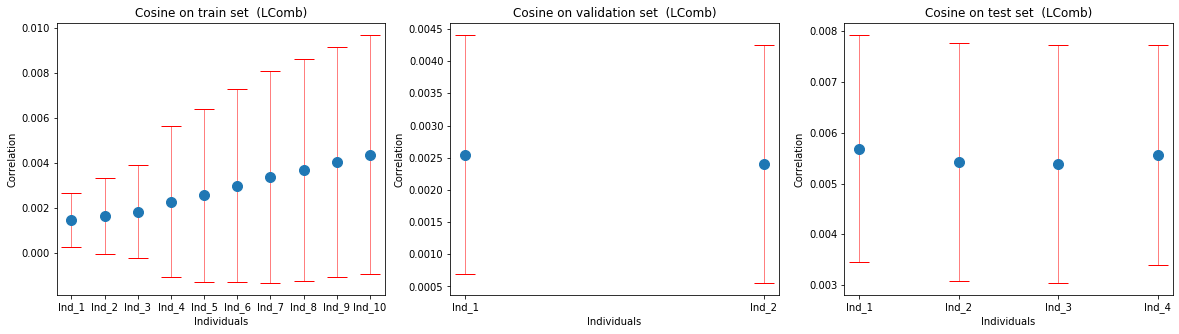

train set mean:  1698.9482706705728
train set std:  259.6831657973035
validation set mean:  2300.9925537109375
validation set std:  387.9059714415648
test set mean:  2527.931292724609
test set std:  928.1392854324989


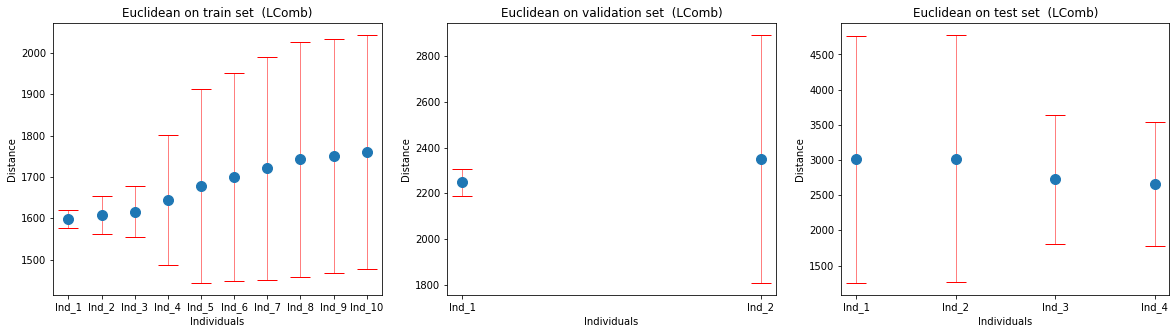

In [7]:
plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [ ]:
eeg_network, bold_network, decoder_network = get_models_and_shapes()

auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                     X_train_bold, 
                     auto_encoder_model, 
                     epochs=40, 
                     auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                     batch_size=batch_size, 
                     X_val_eeg=eeg_val, 
                     X_val_bold=bold_val)

model_name = "AE"

Autoencoder Loss:  0.031403247 || Validation Autoencoder Loss:  0.39103004
Autoencoder Loss:  0.01361588 || Validation Autoencoder Loss:  0.37702167
Autoencoder Loss:  0.0064820633 || Validation Autoencoder Loss:  0.36689487
Autoencoder Loss:  0.005651015 || Validation Autoencoder Loss:  0.36038625
Autoencoder Loss:  0.005143408 || Validation Autoencoder Loss:  0.35339183
Autoencoder Loss:  0.0047556693 || Validation Autoencoder Loss:  0.34493554
Autoencoder Loss:  0.0044147656 || Validation Autoencoder Loss:  0.33515376
Autoencoder Loss:  0.004110843 || Validation Autoencoder Loss:  0.32337794
Autoencoder Loss:  0.00379853 || Validation Autoencoder Loss:  0.3084809
Autoencoder Loss:  0.0034563655 || Validation Autoencoder Loss:  0.2890576
Autoencoder Loss:  0.0030752977 || Validation Autoencoder Loss:  0.26214132
Autoencoder Loss:  0.002639019 || Validation Autoencoder Loss:  0.22209634
Autoencoder Loss:  0.0021442103 || Validation Autoencoder Loss:  0.1596993
Autoencoder Loss:  0.001

In [ ]:
plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

### Try the same hyperparameters, but in an adversarial training process

In [128]:
eeg_network, bold_network, decoder_network = get_models_and_shapes()
multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

model_name = "GAN"

GAN Encoder Loss:  0.15939626  || GAN Decoder Loss:  3.1093001  || GAN Validation Decoder Loss:  0.6578943  || Train Reconstruction Loss:  0.9200086  || Validation Reconstruction Loss:  0.6578943
GAN Encoder Loss:  0.84074533  || GAN Decoder Loss:  1.5784149  || GAN Validation Decoder Loss:  0.14924704  || Train Reconstruction Loss:  0.21967341  || Validation Reconstruction Loss:  0.14924702
GAN Encoder Loss:  1.6417892  || GAN Decoder Loss:  0.05284015  || GAN Validation Decoder Loss:  0.1404275  || Train Reconstruction Loss:  0.20833859  || Validation Reconstruction Loss:  0.1404275
GAN Encoder Loss:  1.6960887  || GAN Decoder Loss:  0.048830755  || GAN Validation Decoder Loss:  0.13624427  || Train Reconstruction Loss:  0.20296583  || Validation Reconstruction Loss:  0.13624425
GAN Encoder Loss:  1.6913936  || GAN Decoder Loss:  0.048639808  || GAN Validation Decoder Loss:  0.14151789  || Train Reconstruction Loss:  0.21027102  || Validation Reconstruction Loss:  0.14151789
GAN Enco

In [ ]:
plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

### Plot synthesized signal

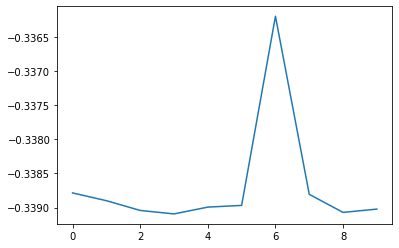

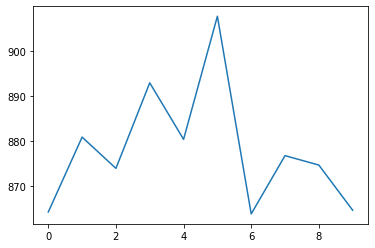

In [30]:
plt.plot(decoder_network(eeg_network(eeg_train))[0][5].numpy())
plt.show()
plt.plot(bold_train[0][5])
plt.show()